<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name
-----

Desi Boyz 

Student Names
----

1. Ash Jha
2. Shishir Kumar
3. Samarth Inani

Load Data
-----

We picked up a regression problem where we had to predict hourly energy consumption of buildings.

[link to the dataset](https://www.kaggle.com/c/ashrae-energy-prediction/data)

The dataset had hourly meter readings and weather data for the year 2016. This meant the train dataset had over 20 million rows. For practical reasons, we decided to instead aggregate them at a daily level and predict only the mean daily meter readings. Below code was used to aggregate data on a daily level.

The daily aggregated data was broken up into 3 pieces and has been shared on our Github repository.

[link to aggregated data](https://github.com/samarthinani94/ml_project)

Let's load up the datasets.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv as csv
import xgboost as xgb
from xgboost import plot_importance
from sklearn.linear_model import Ridge
from matplotlib import pyplot
from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from rfpimp import *
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
sns.set()
%matplotlib inline

In [2]:
data = pd.concat([pd.read_csv('data1.csv'), pd.read_csv('data2.csv'), pd.read_csv('data3.csv')]
                   , axis = 0)

In [3]:
data.drop(data.columns[0], axis=1, inplace=True) ## removing the row index no
data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,day_of_week,month_,day_,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,0,0,1,4,0.0,12.666667,2.428571,4.429167,0.666667,1015.621739,318.333333,4.283333
1,0,1,Education,2720,2004.0,NaN,0,0,1,4,0.0,12.666667,2.428571,4.429167,0.666667,1015.621739,318.333333,4.283333
2,0,2,Education,5376,1991.0,NaN,0,0,1,4,0.0,12.666667,2.428571,4.429167,0.666667,1015.621739,318.333333,4.283333
3,0,3,Education,23685,2002.0,NaN,0,0,1,4,0.0,12.666667,2.428571,4.429167,0.666667,1015.621739,318.333333,4.283333
4,0,4,Education,116607,1975.0,NaN,0,0,1,4,0.0,12.666667,2.428571,4.429167,0.666667,1015.621739,318.333333,4.283333


In [4]:
data.shape

(845701, 18)

Here, we identify columns with nulls. We will not use the `year_built` and `floor_count` variables because we are hesitant to impute data for variables where majority of the data is missing.

In [6]:
col_nulls = (data.isna().sum() / data.shape[0]) * 100
col_nulls.loc[s_nulls>0]

year_built            59.998037
floor_count           82.660893
cloud_coverage         6.957896
precip_depth_1_hr     13.953158
sea_level_pressure     4.105943
dtype: float64

In [7]:
data.describe(include='all')

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,day_of_week,month_,day_,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,845701.000000,845701.000000,845701,845701.000000,338297.000000,146637.000000,845701.000000,845701.000000,845701.000000,845701.000000,8.457010e+05,845701.000000,786858.000000,845701.000000,727699.000000,810977.000000,845701.000000,845701.000000
unique,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,341681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.001370,800.092567,NaN,107709.359699,1968.257144,4.185663,0.663664,3.005098,6.577496,15.762940,2.110146e+03,15.944838,2.440424,7.716198,1.023119,1016.069946,170.927166,3.378418
std,5.100336,427.003416,NaN,117038.604587,30.213302,4.005016,0.931187,1.996983,3.437662,8.821962,1.487509e+05,10.400417,2.324014,9.956159,3.661259,6.699657,71.830708,1.592328
min,0.000000,0.000000,NaN,283.000000,1900.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,-24.925000,0.000000,-30.704167,-1.000000,975.879167,6.500000,0.237500
25%,3.000000,394.000000,NaN,32527.000000,1951.000000,1.000000,0.000000,1.000000,4.000000,8.000000,2.216667e+01,8.875000,0.500000,0.308333,0.000000,1011.716667,116.521739,2.250000
50%,9.000000,896.000000,NaN,72709.000000,1969.000000,3.000000,0.000000,3.000000,7.000000,16.000000,8.546167e+01,17.041667,1.800000,8.533333,0.000000,1016.060870,166.250000,3.104167
75%,13.000000,1180.000000,NaN,139113.000000,1993.000000,6.000000,1.000000,5.000000,10.000000,23.000000,2.771963e+02,23.725000,3.714286,15.679167,0.125000,1020.204167,225.000000,4.220833


Since we don't have the actual test dataset, we will split our dataset into train and test and build prediction model on training set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['meter_reading']), 
                                                    data[['meter_reading']], 
                                                    test_size=0.25, 
                                                    random_state=42, shuffle=True)

Lets take a look at the relationship between predictor and target features. These features came out to be important in our first iteration of the model.

In [9]:
features = ['site_id','building_id','square_feet','meter','month_','air_temperature','dew_temperature',
            'wind_speed','cloud_coverage','wind_direction','day_','precip_depth_1_hr']

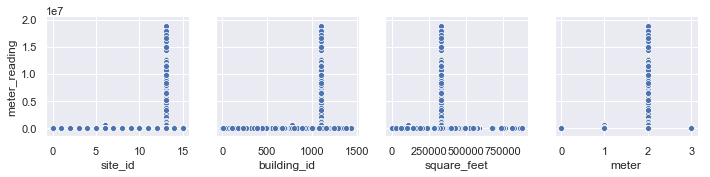

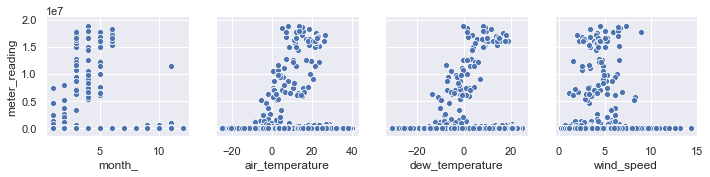

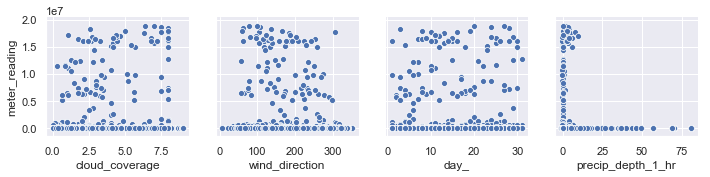

In [10]:
sns.pairplot(pd.concat([X_train,y_train], axis=1), x_vars=features[:4], y_vars='meter_reading')
sns.pairplot(pd.concat([X_train,y_train], axis=1), x_vars=features[4:8], y_vars='meter_reading')
sns.pairplot(pd.concat([X_train,y_train], axis=1), x_vars=features[8:], y_vars='meter_reading')

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((634275, 17), (634275, 1), (211426, 17), (211426, 1))

We will use label encoding technique for the categorical feature `primary_use`.

In [12]:
le = LabelEncoder()
X_train.primary_use = le.fit_transform(X_train['primary_use'])
X_test.primary_use = le.transform(X_test['primary_use'])

In [13]:
X_train.columns = [col.rstrip('_') for col in X_train.columns] 
X_test.columns = [col.rstrip('_') for col in X_test.columns]

In [14]:
X_train.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,day_of_week,month,day,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
29910,13,1180,0,95182,NaN,NaN,2,2,8,24,22.487500,6.400000,17.562500,11.458333,1010.912500,232.173913,3.941667
8992,0,97,4,187647,2007.0,NaN,1,1,5,31,26.466667,3.200000,19.862500,0.333333,1014.045833,206.000000,2.320833
10766,13,1186,4,157070,NaN,NaN,2,1,6,14,20.437500,7.200000,17.362500,1.875000,1010.108696,62.083333,4.408333
198516,3,504,15,112536,NaN,NaN,0,1,10,11,13.516667,1.777778,5.862500,0.000000,1030.029167,186.666667,1.966667
195513,3,481,0,104294,1976.0,NaN,0,1,7,26,31.045833,5.800000,22.183333,0.000000,1013.395833,210.833333,3.212500


Fit scikit-learn model
----

#### 1. Ridge Regression

We will use Ridge Regression to establish a basiline linear model.

We will impute the missing values with the train median values. Also, to improve the generality of the model, we will conduct a randomized search of hyperparameters with a 5-fold cross validation. All this functionality can be easily encapsulated in a pipeline.

In [15]:
num_features_ridge = ['site_id', 'building_id', 'primary_use', 'square_feet', 'meter', 'month',
                'day', 'air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction',
                'cloud_coverage', 'precip_depth_1_hr']

num_transformer_ridge = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                  ('scaler', StandardScaler())])


preprocessor_ridge = ColumnTransformer(transformers=[('num', num_transformer_ridge, num_features_ridge)])



params_ridge = {
    "rcv_ridge__alpha": uniform(0.001, 0.5),
    "rcv_ridge__tol": uniform(1e-6, 1e-3)
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor_ridge),
                           ('rcv_ridge', Ridge(random_state=42))])

search_ridge = RandomizedSearchCV(pipeline, param_distributions=params_ridge, n_iter=20, 
                            scoring='neg_median_absolute_error', random_state=42, cv=5, 
                            n_jobs=4, return_train_score=True)

In [16]:
%%time
search_ridge.fit(X_train[num_features_ridge],y_train)

CPU times: user 3.32 s, sys: 729 ms, total: 4.05 s
Wall time: 2min 13s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                     

[Thanks to this Kaggle tutorial for a neat representation of the hyperparameters for the top performing models.](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn)

In [17]:
def report_best_scores(results, n_top=3):
    """Function gives hyperparameters for the top n models"""
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [18]:
report_best_scores(search_ridge.cv_results_, 3)

Model with rank: 1
Mean validation score: -3639.175 (std: 271.007)
Parameters: {'rcv_ridge__alpha': 0.4838160165372797, 'rcv_ridge__tol': 0.0008093973481164612}

Model with rank: 2
Mean validation score: -3639.191 (std: 271.011)
Parameters: {'rcv_ridge__alpha': 0.41722132040021087, 'rcv_ridge__tol': 0.00021333911067827617}

Model with rank: 3
Mean validation score: -3639.200 (std: 271.017)
Parameters: {'rcv_ridge__alpha': 0.36699697090570255, 'rcv_ridge__tol': 0.0005996584841970366}



#### 2. Random Forests

Tree based algorithms perform better than linear models. Hence we will try out Random forests.

We will impute all the missing values with the median of the train dataset, as done before. We will perform a randomized search with a 5 fold cross validation as done previously.

In [19]:
num_features_rf = ['site_id', 'building_id', 'primary_use', 'square_feet', 'meter', 'month',
                'day', 'air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction',
                'cloud_coverage', 'precip_depth_1_hr']

num_transformer_rf = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

preprocessor_rf = ColumnTransformer(transformers=[('num', num_transformer_rf, num_features_rf)])

regressor_rf = RandomForestRegressor(random_state=42,n_estimators = 50)

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor_rf), ('rcv_rf', regressor_rf)])

params_rf = {
    "rcv_rf__max_features": range(5,14),
    "rcv_rf__max_depth": [10,20,25],
    "rcv_rf__min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
    "rcv_rf__min_samples_leaf": range(1,8),
    "rcv_rf__bootstrap": [True, False]
    
}

search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=params_rf, n_iter=10, 
                            scoring='neg_median_absolute_error', random_state=42, cv=5, 
                            verbose=1, n_jobs=4, return_train_score=True)

In [20]:
%%time
search_rf.fit(X_train[num_features_rf], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 13.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 14.6min finished
/Users/MrMndFkr/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


CPU times: user 1min 23s, sys: 815 ms, total: 1min 24s
Wall time: 15min 57s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                     

In [21]:
report_best_scores(search_rf.cv_results_, 3)

Model with rank: 1
Mean validation score: -136.105 (std: 4.333)
Parameters: {'rcv_rf__min_samples_split': 0.1, 'rcv_rf__min_samples_leaf': 2, 'rcv_rf__max_features': 12, 'rcv_rf__max_depth': 20, 'rcv_rf__bootstrap': True}

Model with rank: 2
Mean validation score: -156.042 (std: 3.440)
Parameters: {'rcv_rf__min_samples_split': 0.1, 'rcv_rf__min_samples_leaf': 3, 'rcv_rf__max_features': 8, 'rcv_rf__max_depth': 20, 'rcv_rf__bootstrap': True}

Model with rank: 3
Mean validation score: -174.541 (std: 28.243)
Parameters: {'rcv_rf__min_samples_split': 0.30000000000000004, 'rcv_rf__min_samples_leaf': 7, 'rcv_rf__max_features': 13, 'rcv_rf__max_depth': 25, 'rcv_rf__bootstrap': False}

Model with rank: 3
Mean validation score: -174.541 (std: 28.243)
Parameters: {'rcv_rf__min_samples_split': 0.30000000000000004, 'rcv_rf__min_samples_leaf': 2, 'rcv_rf__max_features': 13, 'rcv_rf__max_depth': 20, 'rcv_rf__bootstrap': False}



#### 3. XgBoost

This histogram of the target variable clearly shows that its long tailed. Squared error would not be a good loss function.

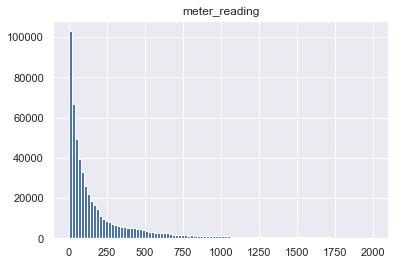

In [22]:
y_train.hist(bins = 100, range = [1,2000]);

We want to optimize for the median of the errors since the distribution is long tailed. We will use a Pseudo Huber loss function, instead of MSE which is very sensitive to outliers.

[Our implementation was inspired by this stackoverflow post](https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function)

In [23]:
def huber_approx_obj(train, preds):
    """
    Function returns gradient and hessein of the Pseudo-Huber function.
    """
    d = preds - train
    h = 1  ## constant
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [24]:
## define huber loss - minimizing it means maximizing its negative
def huber_loss(preds, train):
    d = preds - train
    h = 1
    return -1 * np.sum(np.sqrt(1 + (d/h)**2) - 1)

XgBoost is a very powerful algorithm when it comes to tabular data. Hence we decided to try out the `XGBRegressor` model.

To find out the optimal hyperparameter combination , we will do a randomized search over a hyper-dimensional space, fitting XgBoost models to minimize the validation Pseudo-Huber loss.

We will be fitting a total of 200 XgBoost models by performing a 5-fold cross validation on the train dataset. This will help us improve the generality of the model.

Lets wrap up all this functionality into a pipeline and conduct a randomized search.

In [25]:
num_features_xgb = ['site_id', 'building_id', 'primary_use', 'square_feet', 'meter', 'month',
                'day', 'air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction',
                'cloud_coverage', 'precip_depth_1_hr']

num_transformer_xgb = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

preprocessor_xgb = ColumnTransformer(transformers=[('num', num_transformer_xgb, num_features_xgb)])

params_xgb = {
    "rcv_xgb__colsample_bytree": uniform(0.7, 0.1),
    "rcv_xgb__gamma": uniform(0, 0.2),
    "rcv_xgb__learning_rate": uniform(0.03, 0.12), 
    "rcv_xgb__subsample": uniform(0.8, 0.15),
    "rcv_xgb__booster": ['gbtree','dart']
}

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor_xgb),
                           ('rcv_xgb', xgb.XGBRegressor(objective=huber_approx_obj, 
                                                        feval= huber_loss, max_depth=5,n_estimators=30))])
search_xgb = RandomizedSearchCV(pipeline_xgb, param_distributions=params_xgb, n_iter=10, 
                            scoring='neg_median_absolute_error', random_state=42, cv=5, 
                            verbose=1, n_jobs=4, return_train_score=True)

In [26]:
%%time
search_xgb.fit(X_train[num_features_xgb], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.8min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 14.6min finished


[20:20:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 46.6 s, sys: 958 ms, total: 47.6 s
Wall time: 15min 24s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                     

In [28]:
report_best_scores(search_xgb.cv_results_, 3)

Model with rank: 1
Mean validation score: -48.116 (std: 1.875)
Parameters: {'rcv_xgb__booster': 'dart', 'rcv_xgb__colsample_bytree': 0.71818249672071, 'rcv_xgb__gamma': 0.03668090197068676, 'rcv_xgb__learning_rate': 0.06650906915514453, 'rcv_xgb__subsample': 0.8787134647448357}

Model with rank: 2
Mean validation score: -49.930 (std: 1.657)
Parameters: {'rcv_xgb__booster': 'dart', 'rcv_xgb__colsample_bytree': 0.7023062425041415, 'rcv_xgb__gamma': 0.10495493205167783, 'rcv_xgb__learning_rate': 0.07798331660583066, 'rcv_xgb__subsample': 0.8069998494820424}

Model with rank: 3
Mean validation score: -50.550 (std: 1.333)
Parameters: {'rcv_xgb__booster': 'gbtree', 'rcv_xgb__colsample_bytree': 0.7015966252220214, 'rcv_xgb__gamma': 0.0461787651244298, 'rcv_xgb__learning_rate': 0.0589230559231214, 'rcv_xgb__subsample': 0.9024895278238187}



Evaluation Metric
----

A histogram of the target variable is long tailed. We will use the Median Absolute Error as our North Star evaluation metric.

In [30]:
y_train_pred_ridge = search_ridge.predict(X_train[num_features_ridge]) 
y_test_pred_ridge = search_ridge.predict(X_test[num_features_ridge])
y_train_pred_rf = search_rf.predict(X_train[num_features_rf]) 
y_test_pred_rf = search_rf.predict(X_test[num_features_rf])
y_train_pred_xgb = search_xgb.predict(X_train[num_features_xgb]) 
y_test_pred_xgb = search_xgb.predict(X_test[num_features_xgb])

In [31]:
train_medae_ridge = median_absolute_error(y_train, y_train_pred_ridge)
test_medae_ridge = median_absolute_error(y_test, y_test_pred_ridge)
print(f'MEDAE Ridge: Train = {train_medae_ridge:.2f} , Test = {test_medae_ridge:.2f}')

MEDAE Ridge: Train = 3634.70 , Test = 3641.57


In [32]:
train_medae_rf = median_absolute_error(y_train, y_train_pred_rf)
test_medae_rf = median_absolute_error(y_test, y_test_pred_rf)
print(f'MEDAE Random Forests: Train = {train_medae_rf:.2f} , Test = {test_medae_rf:.2f}')

MEDAE Random Forests: Train = 130.81 , Test = 131.48


In [43]:
train_medae_xgb = median_absolute_error(y_train, y_train_pred_xgb)
test_medae_xgb = median_absolute_error(y_test, y_test_pred_xgb)
print(f'MEDAE XGBoost: Train = {train_medae_xgb:.2f} , Test = {test_medae_xgb:.2f}')

MEDAE XGBoost: Train = 51.99 , Test = 52.34


The XGBoost model, being the most powerful for tabular data, gave us the best MedAE value of 42.

We also looked at the RMSE and MAE for our reference.

In [44]:
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print(f'RMSE XGBoost: Train = {train_rmse_xgb:.2f} , Test = {test_rmse_xgb:.2f}')

RMSE XGBoost: Train = 149167.56 , Test = 147508.08


In [146]:
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
print(f'MAE XGBoost: Train = {train_mae_xgb:.2f} , Test = {test_mae_xgb:.2f}')

MAE XGBoost: Train = 2035.61 , Test = 1950.99


In [147]:
train_medae = huber_loss(y_train.values.ravel(), y_train_pred_xgb)
test_medae = huber_loss(y_test.values.ravel(), y_test_pred_xgb)
print(f'Huber Loss XGBoost: Train = {train_medae:.2f} , Test = {test_medae:.2f}')

Huber Loss XGBoost: Train = -1290536318.30 , Test = -412289289.19


Feature Importances
---

The square feet area of the buidling and its meter type turn out to be two the most important variables

In [144]:
I_ridge = importances(search_ridge.best_estimator_, X_test[num_features_ridge], y_test)
I_rf = importances(search_rf.best_estimator_, X_test[num_features_rf], y_test)
I_xgb = importances(search_xgb.best_estimator_, X_test[num_features_xgb], y_test)
I = pd.concat([I_ridge,I_rf,I_xgb], axis=1, sort=False).reset_index()
I.columns = ['feature','ridge','random_forest','xgboost']

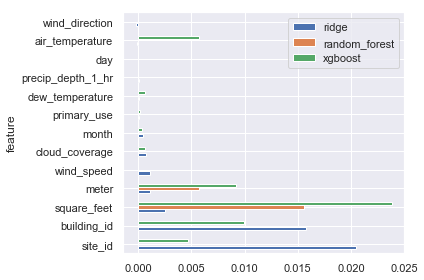

In [145]:
I.plot.barh(x='feature',y=['ridge', 'random_forest', 'xgboost'])
plt.tight_layout()
#plt.savefig("/Users/MrMndFkr/Desktop/Importance.pdf")

Model Visualization
---

In [ ]:
# Plotting first tree from the list of best estimators from the random forest 
estimator = search_rf.best_estimator_[0]


# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = num_features_rf,
                class_names = 'meter_reading',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook

Image(filename = 'tree.png')

We fit the best XGBoost model from randomised search with cross validation.

In [132]:
xgb_model = xgb.XGBRegressor(objective=huber_approx_obj, feval= huber_loss,booster='dart',
                             colsample_bytree=0.71818249672071, gamma=0.03668090197068676,
                            learning_rate=0.06650906915514453, max_depth=5, n_estimators=30, 
                             subsample=0.8787134647448357)
xgb_model.fit(X_train[num_features_xgb], y_train)

[21:29:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.71818249672071,
             feval=<function huber_loss at 0x1035ccb70>,
             gamma=0.03668090197068676, importance_type='gain',
             learning_rate=0.06650906915514453, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
             nthread=None,
             objective=<function huber_approx_obj at 0x1a1a842950>,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8787134647448357, verbosity=1)

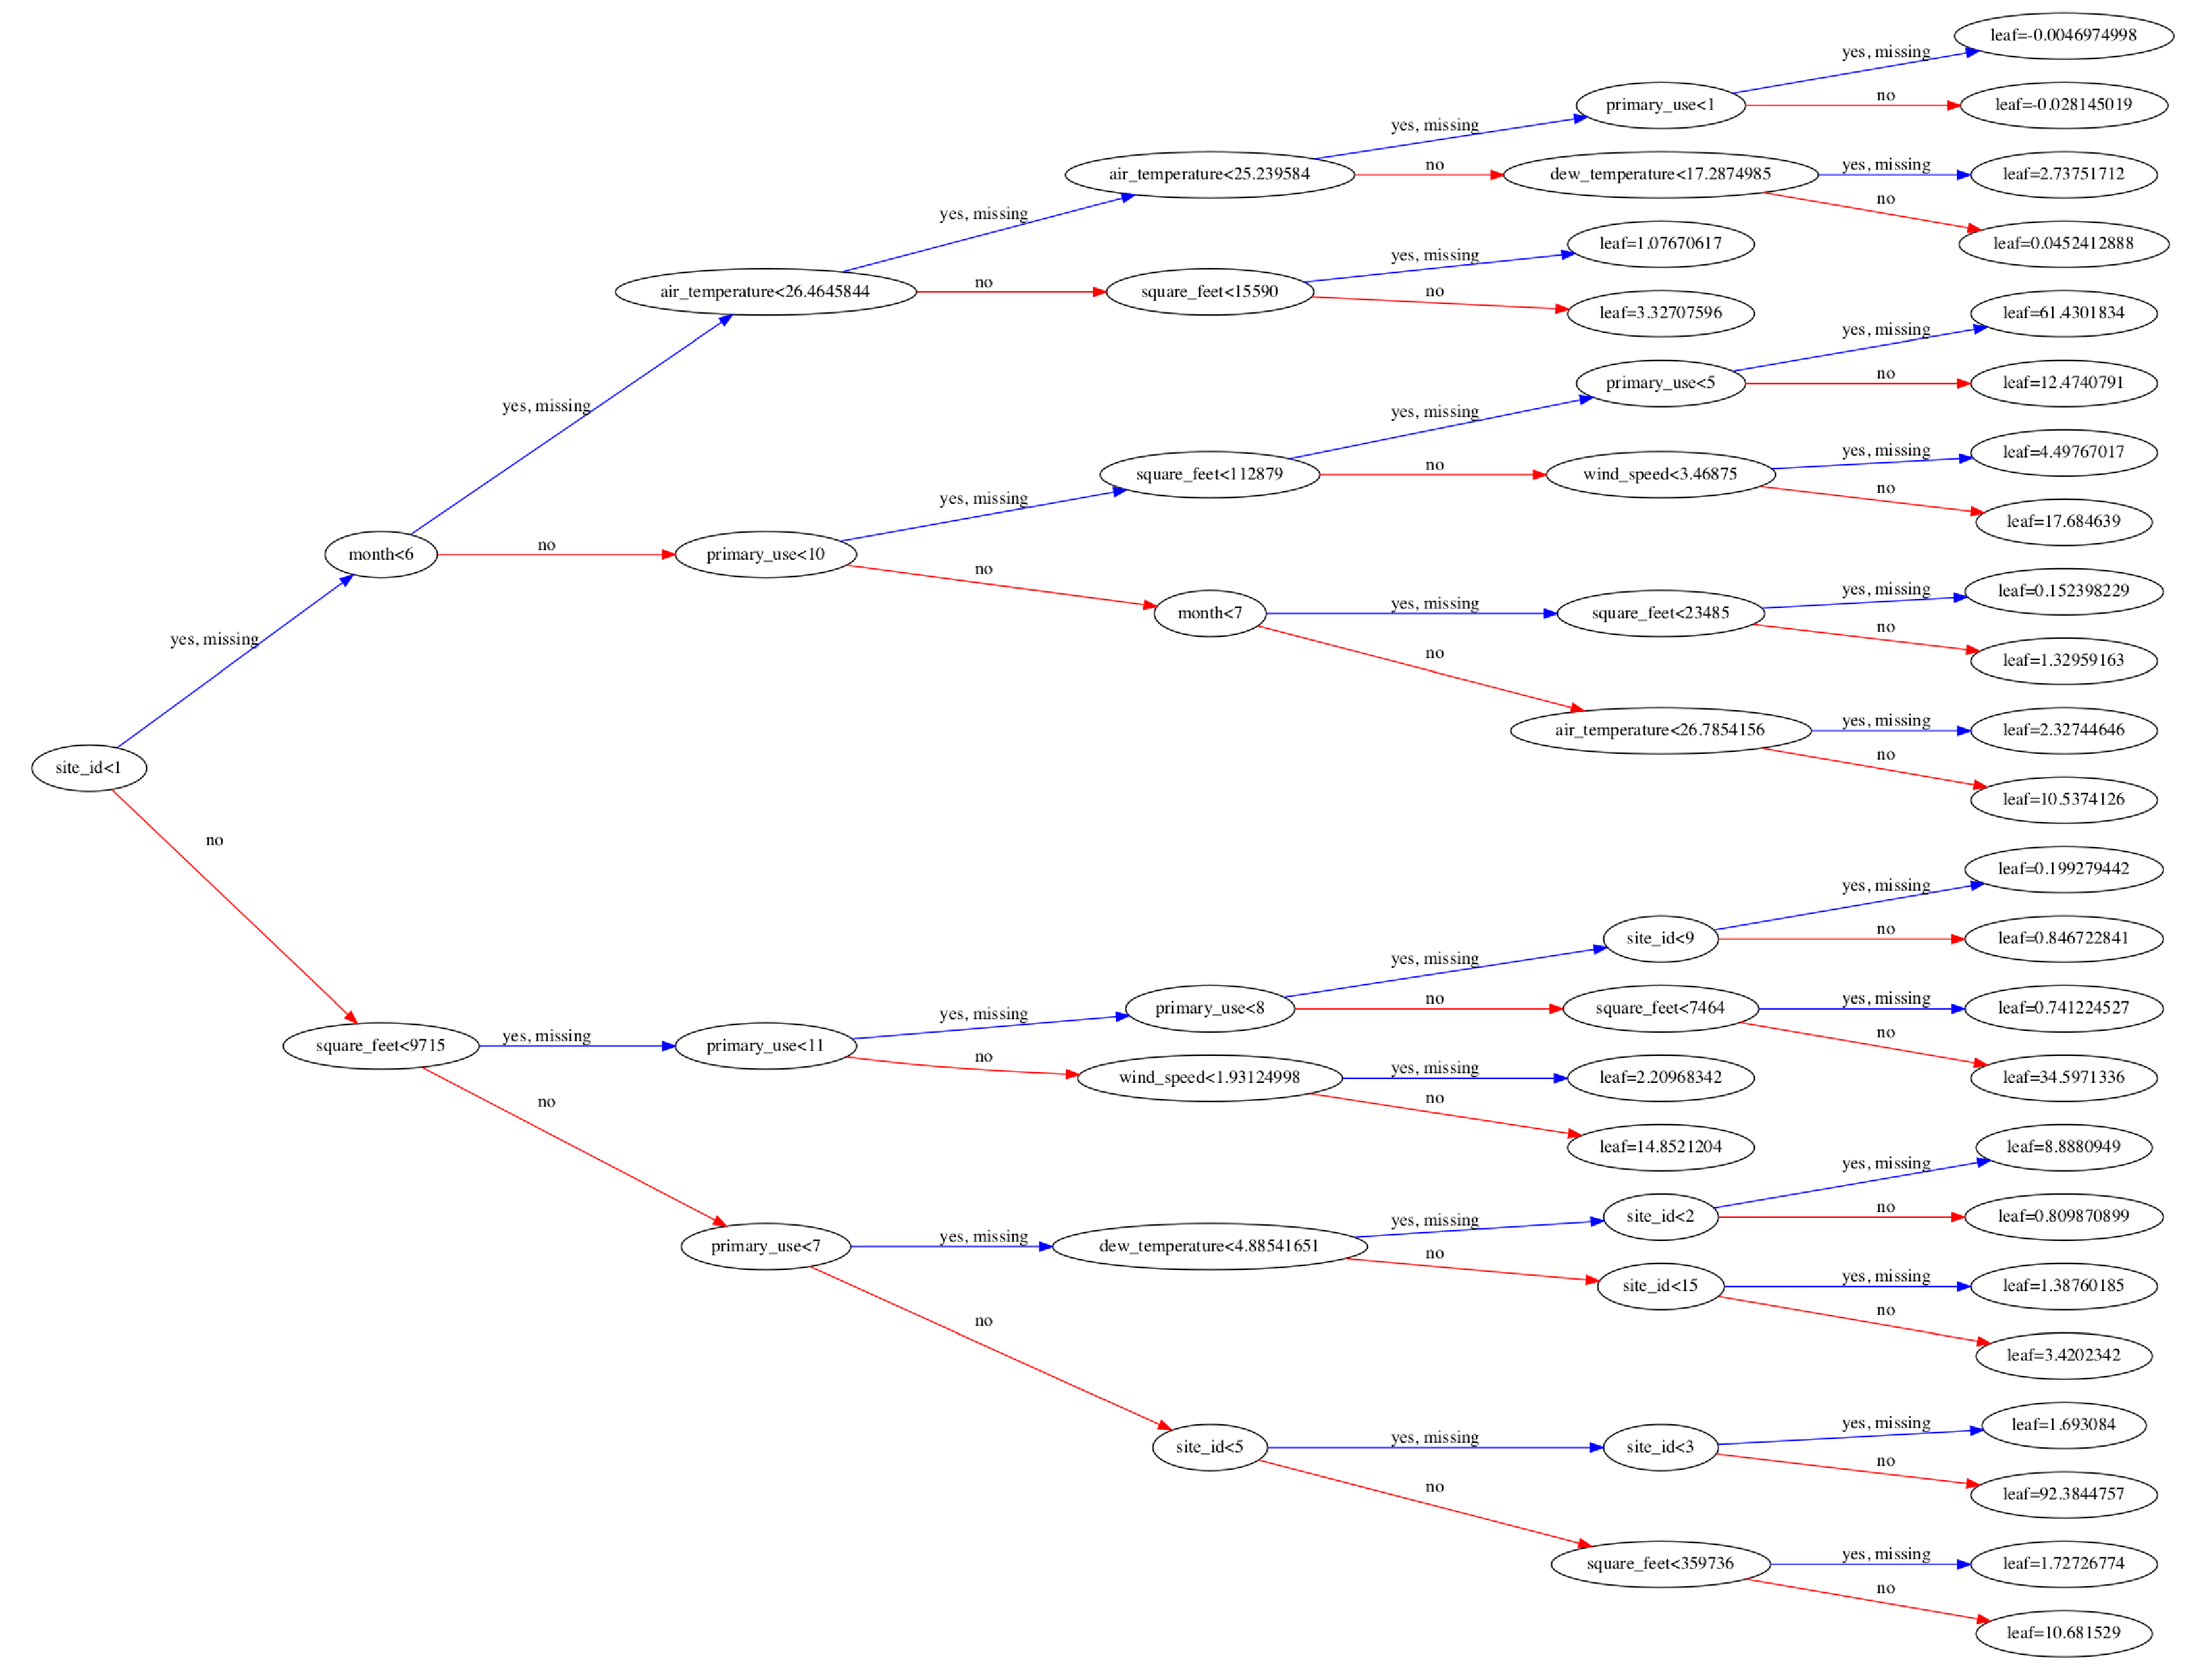

In [133]:
fig, ax = plt.subplots(figsize=(60, 60))
xgb.plot_tree(xgb_model, num_trees=0, ax=ax, rankdir='LR')
#plt.savefig("/Users/MrMndFkr/Desktop/xgboost.pdf")
plt.show()

Conclusion
---

We can predict the mean hourly energy consumption of a building every day from building characteristics and weather information. Our best model gives meter reading predictions that are off only by 42 units, most of the times.